In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd


from utils import load_egraph_data


data_dir = "../../data/"

egraph_data = {}

for direc in os.listdir(data_dir):
    egraph_data[direc] = (
        load_egraph_data(f"{data_dir}{direc}/egraph_stats.json"),
        load_egraph_data(f"{data_dir}{direc}/egraph_stats_mem.json"),
    )

egraph_data

{'alive_arith': ({'Select_1105': {'summary': {'iterations': 1,
     'stop_reason': {'Other': 'Found equivalence'},
     'egraph_nodes': 6,
     'egraph_classes': 5,
     'memo_size': 6,
     'rebuilds': 0,
     'total_time': 3.61e-07,
     'search_time': 2e-08,
     'apply_time': 1.51e-07,
     'rebuild_time': 1.6e-07},
    'memory_footprint': None,
    'crude_time': 0.000332731,
    'iteration_info': [{'egraph_nodes': 6,
      'egraph_classes': 5,
      'applied': {},
      'hook_time': 2.104e-06,
      'search_time': 2e-08,
      'apply_time': 1.51e-07,
      'rebuild_time': 1.6e-07,
      'total_time': 3.61e-07,
      'data': None,
      'n_rebuilds': 0,
      'stop_reason': {'Other': 'Found equivalence'}}]},
   'AddSub_1619': {'summary': {'iterations': 6,
     'stop_reason': {'Other': 'Found equivalence'},
     'egraph_nodes': 725,
     'egraph_classes': 214,
     'memo_size': 937,
     'rebuilds': 63,
     'total_time': 0.001938116,
     'search_time': 0.0005426719999999999,
     

In [6]:
def prepare_step_data(series):
    times = sorted(series)
    x = [0]
    y = [0]
    for i, t in enumerate(times, start=1):
        x.extend([t, t])
        y.extend([y[-1], i])
    return x, y


out_color_map = {
    "Saturated": "red",
    "Timeout": "blue",
    "NodeLimit": "purple",
}


def create_cactus_plot(df):
    # Separate solved and unsolved entries
    solved = df[df["outcome"] == "Equivalent"].copy()
    unsolved = df[df["outcome"] != "Equivalent"].copy()

    assert len(solved) + len(unsolved) == len(df)

    print(len(df), len(solved), len(unsolved), solved.index)
    solved.sort_values("runtime", inplace=True)
    fig, ax = plt.subplots(figsize=(6, 10))

    x, y = prepare_step_data(solved["runtime"])
    ax.plot(x, y, "-", drawstyle="steps-post")

    ax.set_xlabel("Cumulative Runtime (Seconds)")
    ax.set_ylabel("Number of Problems Solved")
    ax.set_title("Cactus Plot of Problem Solving Performance")
    ax.grid(True, linestyle="--", alpha=0.7)
    # plt.legend()
    ax.set_xscale("log")
    ax.set_ylim(0, len(df))
    if len(unsolved) > 0:
        ax.axhline(len(solved), color="red", linestyle="dashed")
        current_yticks = list(ax.get_yticks())
        if len(solved) not in current_yticks:
            current_yticks.append(len(solved))
            ax.set_yticks(sorted(current_yticks))
    ax.set_ylim(0, len(df)) 

    # Create a second y-axis with problem names
    ax2 = ax.twinx()
    new_ticks = [*range(0, len(df) + 1)]
    ax2.set_yticks(new_ticks)

    ax2.set_yticklabels(
        [
            f"{i} {name}"
            for i, name in enumerate([""] + [*solved.index] + [*unsolved.index])
        ]
    )
    ax2.set_ylim(ax.get_ylim())
    if len(unsolved) > 0:
        for i, out in enumerate(unsolved.outcome):
            ax2.get_yticklabels()[i + len(solved) + 1].set_color(out_color_map[out])

    # Adjust layout
    plt.tight_layout()
    plt.show()

14 14 0 Index(['Select_1100', 'Select_1105', 'muldivrem_152', 'AddSub_1539_2',
       'muldivrem_290_292', 'AddSub_1176', 'AddSub_1164', 'AddSub_1574',
       'muldivrem_229', 'AddSub_1165', 'InstCombineShift497d', 'AddSub_1619',
       'AddSub_1614', 'muldivrem_239'],
      dtype='object')


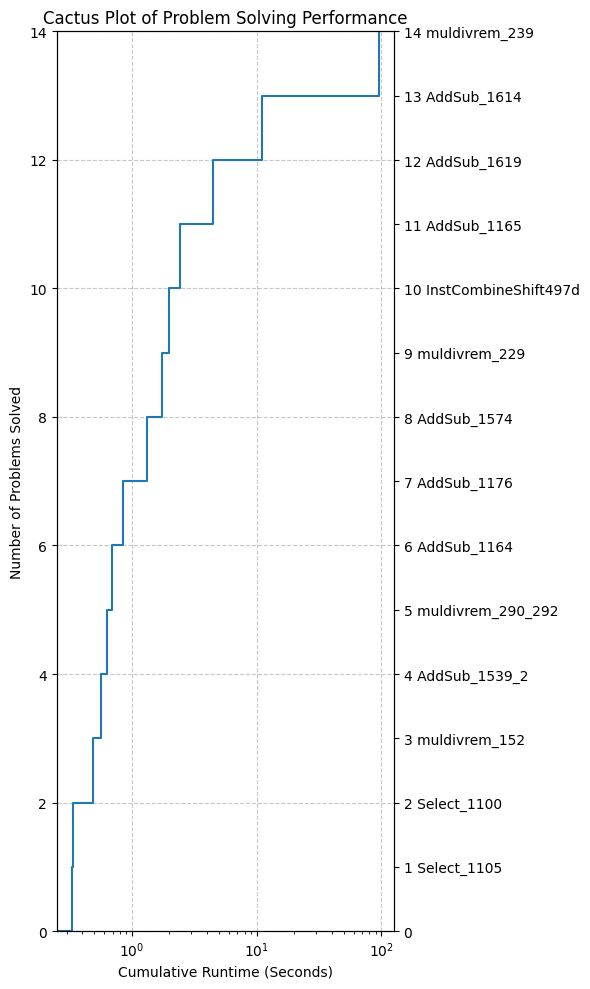

                     Proof Result Run-time (ms)  Nodes E-classes Iterations  \
Select_1100            Equivalent         0.335      6         5          1   
Select_1105            Equivalent         0.333      6         5          1   
muldivrem_152          Equivalent         0.486     55        31          3   
AddSub_1539_2          Equivalent         0.564     81        45          3   
muldivrem_290_292      Equivalent         0.637     65        40          3   
AddSub_1176            Equivalent         0.853     99        53          3   
AddSub_1164            Equivalent         0.692     99        53          3   
AddSub_1574            Equivalent         1.322    297       131          4   
muldivrem_229          Equivalent         1.751    221       106          4   
AddSub_1165            Equivalent         2.445    284       120          4   
InstCombineShift497d   Equivalent         1.979    266       115          5   
AddSub_1619            Equivalent         4.460    7

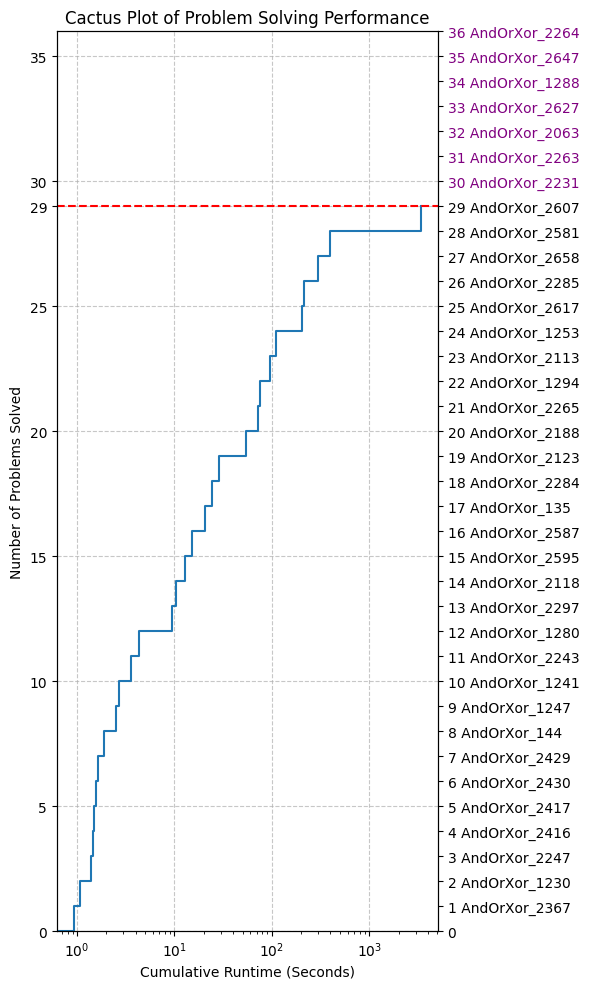

              Proof Result Run-time (ms)    Nodes E-classes Iterations  \
AndOrXor_2367   Equivalent         0.937       66        40          3   
AndOrXor_1230   Equivalent         1.080       82        34          3   
AndOrXor_2416   Equivalent         1.472       82        34          3   
AndOrXor_2417   Equivalent         1.479       81        33          3   
AndOrXor_2247   Equivalent         1.394       78        32          3   
AndOrXor_2430   Equivalent         1.560       82        34          3   
AndOrXor_2429   Equivalent         1.648       78        32          3   
AndOrXor_144    Equivalent         1.891       81        37          6   
AndOrXor_1247   Equivalent         2.509      158        60          4   
AndOrXor_1241   Equivalent         2.690      158        60          4   
AndOrXor_2243   Equivalent         3.626       84        37          8   
AndOrXor_1280   Equivalent         4.323      165        51          5   
AndOrXor_2297   Equivalent         9.3

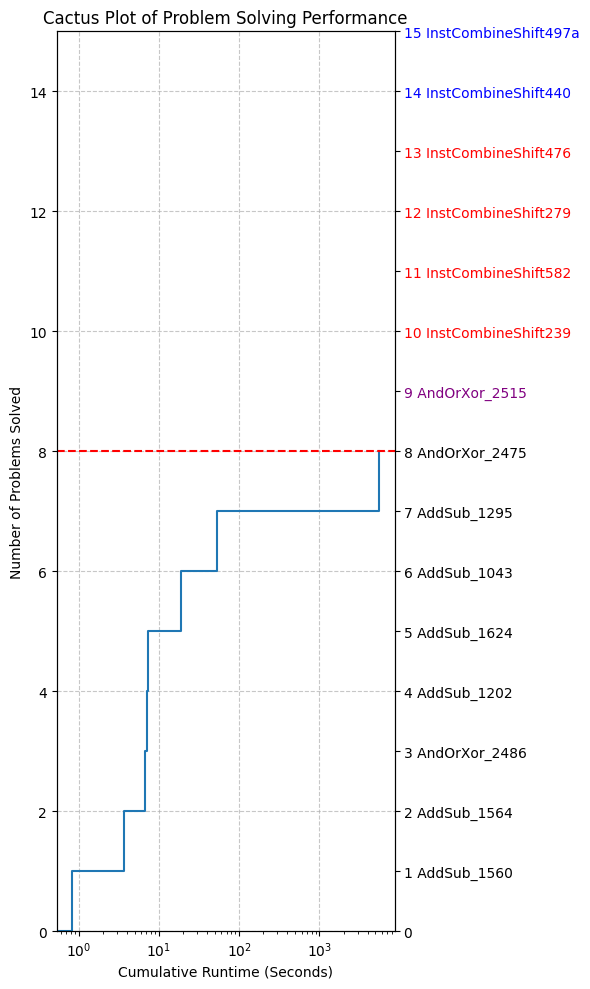

                     Proof Result Run-time (ms)     Nodes E-classes  \
AddSub_1560            Equivalent         0.833        55        26   
AddSub_1564            Equivalent         3.708       445       165   
AddSub_1202            Equivalent         7.204       481       169   
AndOrXor_2486          Equivalent         6.692       475       164   
AddSub_1624            Equivalent         7.323      1013       217   
AddSub_1043            Equivalent        18.835      1528       470   
AddSub_1295            Equivalent        52.287      2721       865   
AndOrXor_2475          Equivalent      5560.686      7325      1887   
AndOrXor_2515           NodeLimit       968.180    113958     48247   
InstCombineShift239     Saturated         0.598        71        46   
InstCombineShift582     Saturated         0.655        71        46   
InstCombineShift279     Saturated         0.939        79        48   
InstCombineShift476     Saturated         1.513       137        75   
InstCo

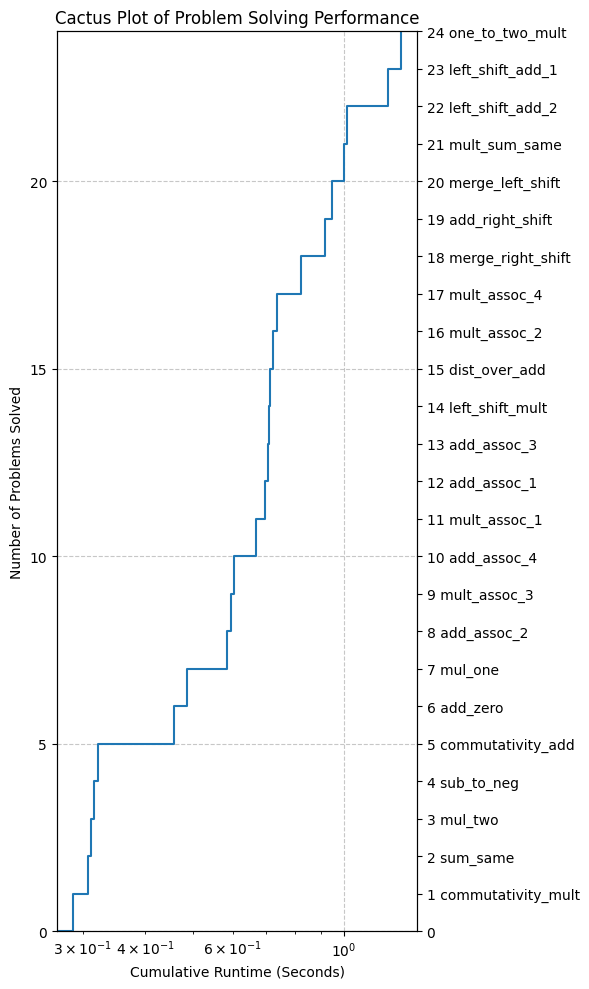

                   Proof Result Run-time (ms) Nodes E-classes Iterations  \
commutativity_add    Equivalent         0.321    30        20          2   
commutativity_mult   Equivalent         0.287    30        20          2   
mul_two              Equivalent         0.312    32        19          2   
sub_to_neg           Equivalent         0.316    36        23          2   
sum_same             Equivalent         0.308    34        21          2   
add_zero             Equivalent         0.457    28        13          4   
mul_one              Equivalent         0.486    29        14          4   
add_assoc_2          Equivalent         0.585    76        41          3   
mult_assoc_3         Equivalent         0.596    74        41          3   
add_assoc_4          Equivalent         0.604    73        38          3   
add_assoc_1          Equivalent         0.695    81        43          4   
dist_over_add        Equivalent         0.712    87        46          4   
left_shift_m

In [7]:
def parse_stop(stop):
    match stop:
        case "Saturated":
            return "Saturated"
        case {"Other": "Found equivalence"}:
            return "Equivalent"
        case {"TimeLimit": _limit}:
            return "Timeout"
        case {"NodeLimit": _limit}:
            return "NodeLimit"
        case err:
            raise NotImplementedError(f"This shouldn't happen {err}")


def format_bytes(size_bytes: int) -> str:
    """Convert bytes to a human-readable format (e.g., KB, MB, GB)."""
    # if size_bytes == 0:
    #     return "0B"
    # units = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    # power = 2 ** 10  # 1024 (binary system)
    # for unit in units:
    #     if size_bytes < power:
    #         return f"{size_bytes:.0f} {unit}"
    #     size_bytes /= power
    # return f"{size_bytes:.2f} YB"  # Fallback (unlikely)
    # convert to MB
    return f"{size_bytes / 2**20:.2f}"


out_dir = "../../out/results/"
os.makedirs(out_dir, exist_ok=True)

dataframes = []

for test_set, (data, data_mem) in egraph_data.items():
    processed = {theorem: entry["summary"] for theorem, entry in data.items()}
    for theorem, info in data_mem.items():
        processed[theorem]["memory"] = format_bytes(int(info["memory_footprint"]))
    for theorem, info in data.items():
        # use the crude time since it feels more correct, also convert to milliseconds
        processed[theorem]["runtime"] = info['crude_time'] * 1000
    df = pd.DataFrame(processed)
    df = df.transpose()
    df["stop_reason"] = df["stop_reason"].map(parse_stop)

    df = df.sort_values(by=["stop_reason", "total_time"])

    dataframes.append(df)

    out_df = df[
        [
            "stop_reason",
            "runtime",
            "egraph_nodes",
            "egraph_classes",
            "iterations",
            "memory",
        ]
    ].copy()

    create_cactus_plot(
        out_df.rename(columns={"stop_reason": "outcome"})
    )
    out_df["runtime"] = df["runtime"].map(lambda x: f"{x:.3f}")

    out_df.rename(
        columns={
            "stop_reason": "Proof Result",
            "runtime": "Run-time (ms)",
            "egraph_nodes": "Nodes",
            "egraph_classes": "E-classes",
            "iterations": "Iterations",
            "memory": "Memory (MB)"
        },
        inplace=True,
    )
    with open(f"{out_dir}{test_set}.tex", "w") as f:
        f.write(out_df.to_latex().replace("_", r"\_"))

    print(out_df)

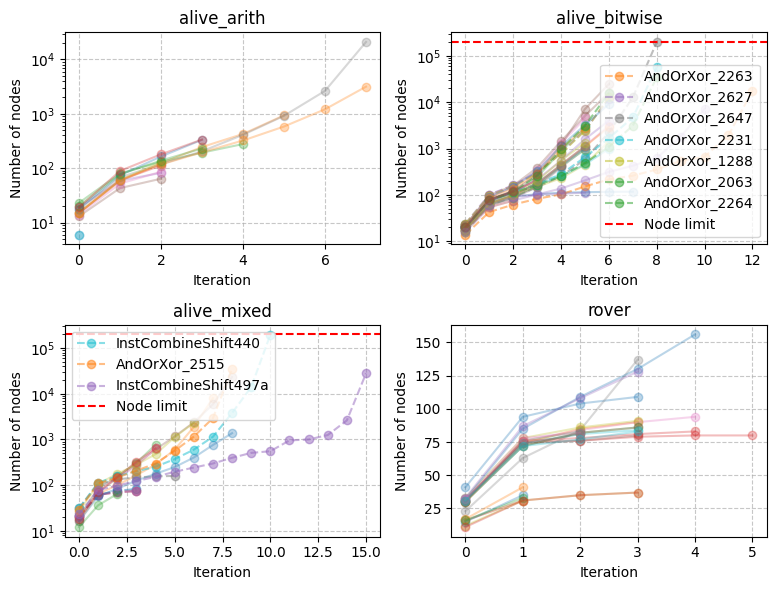

In [10]:
import numpy as np

NODE_LIMIT = 200_000

# get the non memory data
rover_data = egraph_data['alive_mixed'][0]

fig, axs = plt.subplots(2,2, figsize=(8,6))

for i, (bench, data) in enumerate(egraph_data.items()):
    ax = axs[i//2][i%2]
    any_unproven = False
    
    diffs = []
    maxs = []
    for theorem, info in data[0].items():
            
        iter_data = info['iteration_info']
        
        y = []
        x = []
        x = [*range(0, len(iter_data))]
        for it in iter_data:
            # x.append((x[-1] if x != [] else 0) + it['total_time'])
            
            y.append(it['egraph_nodes'])
            # y.append(it['egraph_classes'])
            # y.append(sum([v for _k, v in it['applied'].items()]))
            # y.append(len(y) + 1)

        is_unproven = False
        satured = False
        if (reason:= info['summary']['stop_reason']) != {'Other': 'Found equivalence'}:
            satured = reason == 'Saturated'
                # ax.text(x[-1], y[-1], theorem, horizontalalignment='center')
            is_unproven = True
        
        if is_unproven:
            if  satured:
                ax.plot(x, y,'--o', alpha=0.5)
            else:
                ax.plot(x, y,'--o', alpha=0.5, label=theorem)
        else:
            ax.plot(x, y,'-o', alpha=0.3)
        
        if (non_zero:= [t for t in y if t != 0]) != []:
            diffs.append(max(y) / min(non_zero))
        maxs.append(max(y))
        any_unproven |= is_unproven
    
    if any([abs(m - NODE_LIMIT) < 10000 for m in maxs]):
        ax.axhline(NODE_LIMIT, color='red', linestyle='dashed', label='Node limit')
    
    ax.set_title(bench)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Number of nodes')
    # ax.set_yscale('function', functions=(lambda x: np.log(np.log(x)), lambda x: np.exp(np.exp(x))))
    if max(diffs) > 100:
        ax.set_yscale('log')
    if any_unproven:
        ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.savefig(f"{out_dir}bench_compare_nodes.pdf")
plt.show()